In [1]:
%cd ..

/home/lois/pojetos/ds4a/notebook


## De-biasing Notebook

Goal: Develop a procedure to de-bias time2respond and time2close metrics

### Investigation of higher values

From our previous explorations, we discovered two dynamics that arise in this data. First, high values from "days until resolution" are due to users forgetting to close the complaint ticket and only doing it years later (when they probably logged backed to the website for another complaint). Second, the unsual high values for "days to first reply" are due to company revisiting older complaints and asking the user to close the ticket (probably to increase their response rate that is shown at their profile screen). We will take this in consideration when modeling and further analysis.

In [2]:
from src.loading import load_dataset
from src.cleaning import build_df_from_RA

reviewsRA = load_dataset("dataset")
df = build_df_from_RA(reviewsRA)
print(f"We have a total of {len(reviewsRA)} reviews!")

We have a total of 10688 reviews!


In [3]:
df.describe()

,days_to_resolution,days_to_first_contact,service_grade
count,4072.000000,8920.000000,988.000000
mean,66.119597,14.841816,6.424089
std,174.055450,52.589969,1.928643
min,0.000000,0.000000,3.000000
25%,2.000000,0.000000,4.000000
50%,10.000000,2.000000,7.000000
75%,41.000000,10.000000,8.000000
max,1884.000000,833.000000,8.000000


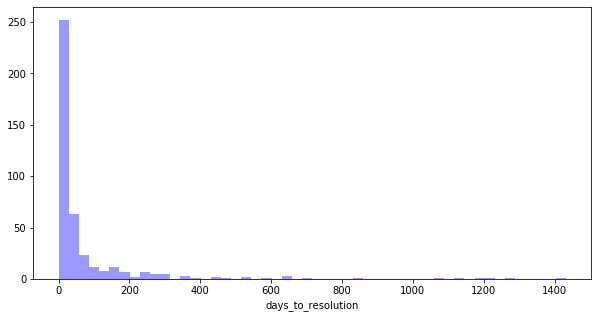

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(10, 5))
sns.distplot(df.dropna().days_to_resolution, kde=False, color="b", ax=ax)

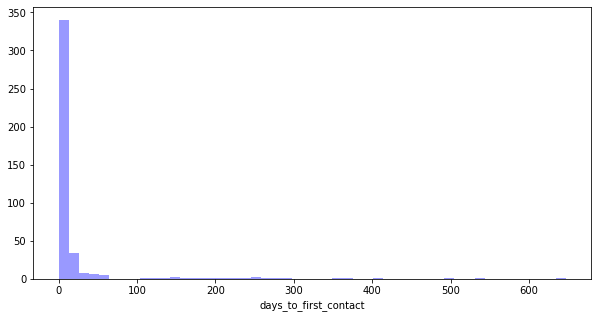

In [5]:

fig,ax = plt.subplots(figsize=(10, 5))
sns.distplot(df.dropna().days_to_first_contact, kde=False, color="b", ax=ax)

## Model

We will model the count data for both variables. We will aproximate their behavior as a mixture model of a Poison/Exponential distribution and an uniform distribution. The idea is that the regular dynamic in both cases could be modeled by a Poison/Exponential distribution and after a time t you would have a uniform distribution, representing the new dynamic. Thus, for the "days to first contact", we expect that new complaints are answered as fast as the company can (i.e. process that can be captured by the Poison/Exponential distribution) and any very long delays are due to the company going back and just replying them to increase their stats (i.e. after a t there is no information on why a company would answer one or the other regarding time differences, so we choose a uniform distribution).

Our main interest is to find a reasonable estimate for t (i.e. the lower bound of the uniform distribution), because that will determine our cutting point when estimating new desciptive statistics for our variables. We will use the pomegranate library to perform EM optimization over many different parameter starting points and then analyse the top convergent points to see if we can find points that are reasonable to the effects we observe.


In [10]:
import pomegranate as pome


dataset_resol = df.days_to_resolution.dropna().value_counts().values

# Doing EM for N times trying to see if it has stable parameters
lambs = []
uni_alfa = []
uni_beta = []
for i in range(5000):
    
    # We tried Poison, but the exponential dist got better results in terms of similarity of the posterior. Nevertheless, we got the the same target values for the uniform distribution.
    #model = pome.GeneralMixtureModel.from_samples([pome.PoissonDistribution, pome.UniformDistribution], n_components=2, X=dataset_resol.reshape([dataset_resol.size,1]))
    
    model = pome.GeneralMixtureModel.from_samples([pome.ExponentialDistribution, pome.UniformDistribution], n_components=2, X=dataset_resol.reshape([dataset_resol.size,1]))
    for d in model.distributions:
        if d.name == "ExponentialDistribution":
            lambs.append(d.parameters[0])
        else:
            uni_alfa.append(d.parameters[0])
            uni_beta.append(d.parameters[1])



In [15]:
import pandas as pd
import numpy as np

params = pd.DataFrame(np.array([lambs, uni_alfa, uni_beta]).transpose(), columns=["lambda", "alfa", "beta"])
params["round_lamb"] = round(1/params["lambda"], 2)
params.head()

,lambda,alfa,beta,round_lamb
0,0.021497,1.0,9.0,46.52
1,0.029179,1.0,4.0,34.27
2,0.015930,1.0,26.0,62.77
3,0.016670,1.0,23.0,59.99
4,0.017337,1.0,15.0,57.68


In [16]:
params.groupby(["round_lamb", "alfa"]).count()

lambda  beta
round_lamb alfa               
2.51       10.0      383   383
           11.0        1     1
2.54       14.0      333   333
2.57       17.0      153   153
2.59       19.0        2     2
2.62       20.0      157   157
2.75       22.0       73    73
2.83       24.0       65    65
3.00       27.0       60    60
3.10       29.0       48    48
3.26       33.0       40    40
3.33       34.0       21    21
3.47       36.0       20    20
3.60       40.0       99    99
3.68       45.0       17    17
3.87       57.0       22    22
3.99       59.0       18    18
4.11       65.0       22    22
4.39       69.0       13    13
4.53       72.0       21    21
4.68       79.0       16    16
5.02       113.0      24    24
5.26       128.0      13    13
5.53       143.0       3     3
5.92       1.0         4     4
6.17       180.0       9     9
6.39       1.0         7     7
6.55       247.0      11    11
6.80       1.0         6     6
7.14       1.0         1     1
7.46       1.0        18    18
7.66       1.0        39    39
8.05       1.0        13    13
8.23       1.0        12    12
8.42       1.0        26    26
8.75       1.0        16    16
8.84       1.0        25    25
8.86       1.0        17    17
34.27      1.0      1588  1588
36.63      1.0       112   112
39.64      1.0        10    10
44.87      1.0         2     2
46.52      1.0       529   529
54.99      1.0       246   246
55.44      1.0        75    75
57.68      1.0       151   151
59.24      1.0        55    55
59.99      1.0        77    77
62.77      1.0        32    32
66.62      1.0        32    32
68.32      1.0        41    41
71.18      1.0        28    28
73.58      1.0        31    31
74.85      1.0        55    55
82.00      1.0       108   108

In [20]:
# Fit a model with the reasoanable parameters
d1 = pome.ExponentialDistribution(1/2.54)
d2 = pome.UniformDistribution(14, dataset_resol.size-1)
model = pome.GeneralMixtureModel([d1, d2])
model.fit(dataset_resol)

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "ExponentialDistribution",
            "parameters" : [
                0.22893293061293085
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "UniformDistribution",
            "parameters" : [
                14.0,
                317.0
            ],
            "frozen" : false
        }
    ],
    "weights" : [
        0.9455597776562611,
        0.05444022234373885
    ]
}

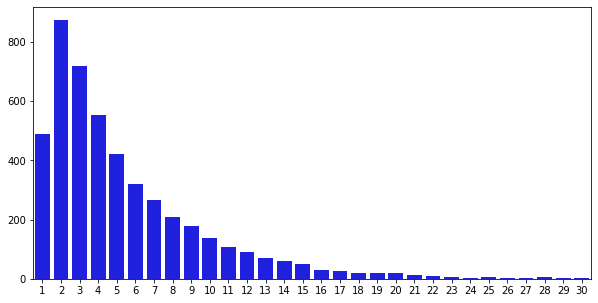

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


# Exponential
fig,ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=np.arange(1,31),y=round(pd.Series(model.sample(5000))).value_counts().sort_index().values[0:30], color="b", ax=ax)

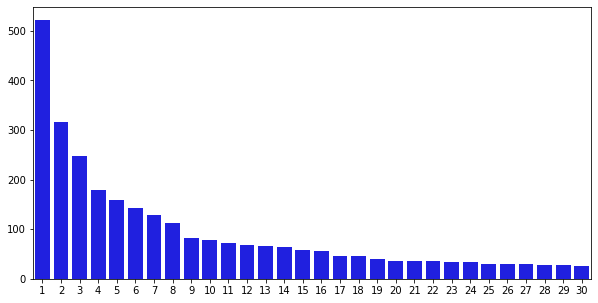

In [22]:
# True count data first 30 days
fig,ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=np.arange(1,31),y=dataset_resol[0:30], color="b", ax=ax)

# days to first response


In [23]:
# Doing EM for N times trying to see if it has stable parameters
rates = []
uni_alfa = []
uni_beta = []

dataset_contact = df.days_to_first_contact.dropna().value_counts().values

for i in range(5000):
    model = pome.GeneralMixtureModel.from_samples([pome.ExponentialDistribution, pome.UniformDistribution], n_components=2, X=dataset_contact.reshape([dataset_contact.size,1]))
    for d in model.distributions:
        if d.name == "ExponentialDistribution":
            rates.append(d.parameters[0])
        else:
            uni_alfa.append(d.parameters[0])
            uni_beta.append(d.parameters[1])
            
params = pd.DataFrame(np.array([rates, uni_alfa, uni_beta]).transpose(), columns=["rate", "alfa", "beta"])


In [24]:
params["round_rate"] = round(params["rate"],2)
params.groupby(["round_rate", "alfa"]).count()

rate  beta
round_rate alfa              
0.00       1.0     1892  1892
0.01       1.0     1200  1200
0.04       1.0       12    12
0.05       inf       19    19
0.06       1071.0    24    24
0.07       721.0     40    40
0.08       323.0     21    21
           468.0     16    16
0.09       269.0     67    67
0.10       198.0    139   139
           214.0     25    25
0.12       152.0     48    48
0.13       133.0     18    18
           150.0      3     3
0.15       122.0     25    25
0.16       116.0    112   112
0.17       96.0     170   170
0.19       78.0     134   134
0.21       69.0     126   126
0.22       62.0     128   128
0.23       55.0     332   332
0.27       36.0     449   449

## Preliminary conclusions: 

> Days to first contact -> 36 to 55 days

We estimate that after one or two months, any first reply made by the company is due to their incentives to revisit old unanswered complaints to increase their reply metric at Reclame Aqui. The estimates are resoanable also beacause we do not expect to see companies carrying a backlog of two+ months of unanswered complaints.

> Days to resolution -> 14 days to 20 days

We estimate that for any complaint solved within a resoanable time frame (2 weeks), if the customer does not close his complaint (by going back to the website and mark it as completed) he will not do it within a reasonable timeframe (e.g. he will close it once he got another problem and logged back to Reclame Aqui again).

We will investigate the conversations to validate our findings and then proceed to limit our sample estimates to these ranges.


## Validation

In [34]:
from src.cleaning import extract_days_to_first_contact, extract_days_to_resolution
from pprint import pprint


def get_complaints_after_cut(contact_cut, resol_cut,company_name,top_n=3):
    # Lets get top_n examples of complaints that falls after the cutting point
    exs_contact = []
    exs_resolution = []

    for r in reviewsRA:
        d2contact = extract_days_to_first_contact(r)
        d2resol = extract_days_to_resolution(r)
        if not isinstance(d2contact, type(np.nan)) and d2contact > contact_cut and r["business_name"] == company_name:
            exs_contact.append(r)
        if not isinstance(d2contact, type(np.nan)) and d2resol > resol_cut and r["business_name"] == company_name:
            exs_resolution.append(r)

        if len(exs_contact) >= top_n and len(exs_resolution) >= top_n:
            break
    
    return exs_contact, exs_resolution



In [35]:
days2contact_ex, days2resol_ex = get_complaints_after_cut(20, 55, "Fabrispuma", top_n=3)

pprint(days2contact_ex[0:3])

[{'business_name': 'Fabrispuma',
  'city': 'Sorocaba',
  'datetime': '2015-04-22T10:25:00Z',
  'description': 'TRES MESES DE COMPRA NO CARTÃO,A MESA VEIO COM DEFEITO NOS '
                 'PÉS MONTADOR FES A FICHA DE PEDIDO NA MINHA FRENTE E ATÉ HJ '
                 'NADA RESOLVIDO!!! VINHERAM AQUI NA MINHA CASA NO DIA '
                 '20/04/2015 DISENDO Q ERA A ENTREGA DOS PÉS DA MESA E TROCA '
                 'DAS CADEIRAS Q TAMBÉM VINHERAM COM DEFEITO E NADA FOI '
                 'FEITO!!! A MESA SETAR SUPER INFAUÇA,NÃO PODE FAZER O MINIMO '
                 'DE FORÇA Q ELA TOMBA PRO LADO COMO SE FOSSE CAIR!!!! E AS '
                 'CADEIRAS TODAS MOLENGAS!!! FIZERAM A TROCA DE APENAS UMA '
                 'CADEIRA FOI FEITO O PEDIDO DE DUAS CADEIRAS PRA TROCA!!FUI '
                 'AO MEDICO NESSE DIA MEU MARIDO Q RECEBEU A LOJA NO DIA '
                 '20,04/2015 E AÍ CHEGO EM CASA NADA TINHA SIDO FEITO!!! NEM A '
                 'TROCA DAS CADEIRAS NEM O PÉ DA MES

In [36]:
pprint(days2resol_ex[0:3])

[{'business_name': 'Fabrispuma',
  'city': 'Jundiaí',
  'datetime': '2015-04-25T14:20:00Z',
  'description': 'Boa tarde, eu e meu marido compramos um guarda roupa '
                 'modulado no dia 19 de dezembro, fomos muito bem atendidos, '
                 'levamos todas a medidas,questionamos sobre a altura e o '
                 'vendedor confirmou que daria pois já tinha vendido um jogo '
                 'no mesmo condomínio.  Quando o móveis chegaram já de cara '
                 'notamos que não ira servi. Ligamos na loja e nós informaram '
                 'que deveriamos espera o montador verfica. De fato não coube. '
                 'Ai começou o nosso problema, a loja majdou vários montadores '
                 'para verificar, depois de tanto custo trocaram o modulado. '
                 'Para o nosso azar o produto veio com duas portas com '
                 'defeito. Demovo estamos brigando desde o dia17 de março para '
                 'a assistência técnica, vim tro

In [46]:
days2contact_ex, days2resol_ex = get_complaints_after_cut(20, 55, "Móveis Rainha", top_n=3)

pprint(days2contact_ex[0:3])

[{'business_name': 'Móveis Rainha',
  'city': 'Guarulhos',
  'datetime': '2014-08-24T12:00:00Z',
  'description': 'Em março desse ano Adquiri os moveis para meu '
                 'quarto,sala,banheiro e cozinha na loja  da Rua capitão '
                 'Gabriel,  Centro Guarulhos, paguei tudo a vista e não foi '
                 'barato, pois bem a montagem foi agendada para abril, quando '
                 'os montadores começaram a montar eles me falaram que tinha '
                 'uma semana para fazer toda a montagem, começaram a montar '
                 'lentamente, quando o prazo que eles tinham estavam acabando '
                 'começaram a fazer tudo de qualquer forma, e quando chegou na '
                 'sala para minha surpresa eles alegaram que não daria para '
                 'montar como estava no projeto, e eu disse que diferente do '
                 'que estava no projeto não queria, mesmo assim eles montaram '
                 'e me garantiram que viria algué

In [38]:
set([i["business_name"] for i in reviewsRA])

{'',
 'Casas Bahia - Loja Online',
 'Casas Bahia - Lojas Físicas',
 'Casas Bahia - Marketplace',
 'Etna Home Store',
 'Etna Home Store - Loja Online',
 'Fabrispuma',
 'Inovar Móveis e Colchões',
 'Lider Interiores',
 'Lojas Cem',
 'Lojas Guido',
 'Lojas Lebes',
 'MadeiraMadeira',
 'Magazine Luiza - Loja Física',
 'Magazine Luiza - Loja Online',
 'Marabraz - Loja Online',
 'Marabraz - Lojas Físicas',
 'Mobly',
 'Móveis Rainha',
 'Openbox2',
 'Sylvia Design',
 'TUTTI MÓVEIS',
 'Tok&Stok - Loja Física',
 'Tok&Stok - Loja Online ',
 'Viggore Móveis'}

In [52]:
days2contact_ex, days2resol_ex = get_complaints_after_cut(20, 55, "Sylvia Design", top_n=3)
pprint(days2resol_ex[0:3])

[{'business_name': 'Sylvia Design',
  'city': 'São Paulo',
  'datetime': '2015-04-06T14:52:00Z',
  'description': 'No dia 02 de FEVEREIRO de 2015 realizei a compra de um sofá '
                 'na loja Sylvia Design - LOJA Butantã com prazo de entrega de '
                 '45 a 60 dias e até HOJE não recebi meu sofá. Fazem 2 semanas '
                 'que estou em contato com SAC, mas toda vez que o contato é '
                 'realizado, ninguem sabe me informar o que aconteceu, ninguém '
                 'sabe informar o prazo que o meu pedido será entregue e o '
                 'motivo do imenso ATRASO.Em 06 de ABRIL de 2015 foi feito um '
                 'contato com SAC e a unidade (BUTANTÃ), mas ninguém soube '
                 'informar quando o sofá será entregeu!! Total descaso com o '
                 'consumidor e enorme insatisfação!!! Essa foi a primeiro e '
                 'última vez que comprei nessa loja!!! Não recomendo que '
                 'comprem neste loj

## Conclusion

From a sample of stores that were previously showing high rates for both metrics, we see that our cutting points are indeed filtering out the effects that were described in the beginning.
We see that our descriptive statistics now offer a clearer and reasonable estimates than before.



In [55]:
# Before, no filtering
df.describe()

,days_to_resolution,days_to_first_contact,service_grade
count,4072.000000,8920.000000,988.000000
mean,66.119597,14.841816,6.424089
std,174.055450,52.589969,1.928643
min,0.000000,0.000000,3.000000
25%,2.000000,0.000000,4.000000
50%,10.000000,2.000000,7.000000
75%,41.000000,10.000000,8.000000
max,1884.000000,833.000000,8.000000


In [56]:
# After broader filter
df.loc[(df.days_to_first_contact <= 55) & (df.days_to_resolution <= 20)].describe()

,days_to_resolution,days_to_first_contact,service_grade
count,2505.000000,2505.000000,582.000000
mean,5.386826,1.804391,6.731959
std,5.512843,3.626874,1.772901
min,0.000000,0.000000,3.000000
25%,1.000000,0.000000,7.000000
50%,3.000000,0.000000,7.000000
75%,9.000000,2.000000,8.000000
max,20.000000,47.000000,8.000000


In [57]:
# After strict filter
df.loc[(df.days_to_first_contact <= 36) & (df.days_to_resolution <= 14)].describe()

,days_to_resolution,days_to_first_contact,service_grade
count,2260.000000,2260.000000,514.000000
mean,4.116372,1.380973,6.754864
std,4.087056,2.546685,1.754478
min,0.000000,0.000000,3.000000
25%,1.000000,0.000000,7.000000
50%,3.000000,0.000000,7.000000
75%,7.000000,2.000000,8.000000
max,14.000000,33.000000,8.000000
